In [69]:
import sys
import os
sys.path.append("../")
sys.path.append("../src/")

import torch
from pytorch.model import UNet
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [71]:
# load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet(input_filters=1, filters=64, N=2).to(device)
model = torch.nn.DataParallel(model)
#model.load_state_dict(torch.load("../trained_models/segmentation_mixed_augmented_UNet_1604044090.034343.pth", map_location=device))
model.load_state_dict(torch.load("../trained_models/new_trained_models/model_black_green_greenblurry_UNet_1637763030.8715491.pth", map_location=device))
#model.eval()

<All keys matched successfully>

(960, 1280)


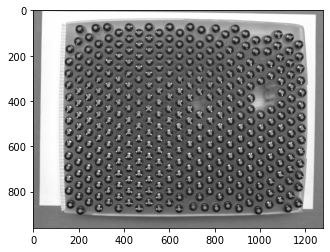

In [72]:
# load image
image = cv2.imread("../dataset/testing/image_1.png", 0)
print(image.shape)
plt.imshow(image, cmap='gray')

In [78]:
from skimage.filters import threshold_otsu
import pytorch.utils as torch_utils
import time

#gray_img = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
resized_image = cv2.resize(image.copy(), (256,256))
tensor_image = torch.unsqueeze(torch.unsqueeze(torch.Tensor(resized_image), 0),0)/255.0

thres = 0.6
# Inference process - Find and count contours (cartridges)
# Method 1: using cv2.findContours()
start_time = time.time()
prediction_prob = model(tensor_image.to(device))[0,0].cpu().detach().numpy()
thred_otsu = threshold_otsu(prediction_prob)
prediction = prediction_prob > thred_otsu

resized_prediction = cv2.resize(prediction.astype(np.uint8)*255, (1280,960))
contours, hierarchy = cv2.findContours(resized_prediction, 1, 2)
predicted_count = len(contours)
time_method1 = time.time() - start_time
print(f'Nb of cartridges using method 1: {predicted_count} - time: {time_method1:.3f}')

# Method 2: Using torch_utils.get_count()
start_time = time.time()
prediction = model(tensor_image.to(device)).detach().cpu().numpy()[0]
thred_otsu = threshold_otsu(prediction[0])
predicted_count = torch_utils.get_count(prediction, thres=thred_otsu)
time_method2 = time.time() - start_time
print(f'Nb of cartridges using method 2: {predicted_count} - time: {time_method2:.3f}')

0.9997454
Nb of cartridges using method 1: 366 - time: 0.466
Nb of cartridges using method 2: 366 - time: 0.542


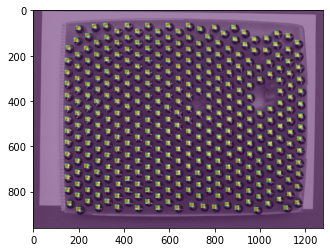

In [74]:
img_size = image.shape
resized_img_size = resized_image.shape
tensor_image = torch.unsqueeze(torch.unsqueeze(torch.Tensor(resized_image), 0),0)/255.0
prediction = model(tensor_image)[0,0].cpu().detach().numpy() > 0.5
# find centers
contours,hierarchy = cv2.findContours(prediction.astype(np.uint8)*255, 1, 2)
def find_center(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx, cy

centers = [find_center(contour) for contour in contours]
adjusted_circles = [(int((x/256)*img_size[1]), int((y/256)*img_size[0])) for (x,y) in centers]

dots = np.zeros(img_size)
for (y,x) in adjusted_circles:
    dots[x-10:x+10,y-10:y+10] = 255

plt.imshow(image, cmap='gray')
plt.imshow(dots, alpha=0.5)

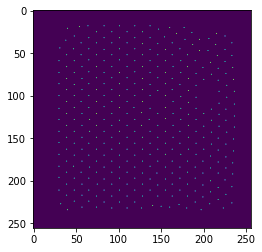

In [75]:
dots = np.zeros((256,256))
for (y,x) in centers:
    dots[x,y] = 255

plt.imshow(dots)